In [96]:
import pandas as pd

# importing json into pandas dataframe structure
proj_df = pd.read_json('combined.json', lines=True)

In [97]:
# this is what our original json file looks like 
proj_df.head()

,components,contents,date,id,title,topics
0,[National Security Division (NSD)],"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01 04:00:00,None,Convicted Bomb Plotter Sentenced to 30 Years,[]
1,[Environment and Natural Resources Division],WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25 04:00:00,12-919,$1 Million in Restitution Payments Announced t...,[]
2,[Environment and Natural Resources Division],BOSTON– A $1-million settlement has been...,2011-08-03 04:00:00,11-1002,$1 Million Settlement Reached for Natural Reso...,[]
3,[Environment and Natural Resources Division],WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08 05:00:00,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,[]
4,[Environment and Natural Resources Division],"The U.S. Department of Justice, the U.S. Envir...",2018-07-09 04:00:00,18-898,$100 Million Settlement Will Speed Cleanup Wor...,[Environment]


In [98]:
# there were originally 13,087 rows and 6 columns 
proj_df.shape

(13087, 6)

**We are focusing only on the last two years (2017 and 2018). So, the next step is to filter our dataset to only those 2 years**

In [103]:
# Filter by last two years
import datetime as dt

proj_df['date'] = pd.to_datetime(proj_df['date'])

df_1718 = proj_df[proj_df['date'].dt.year >= 2017] # 2208 rows, nice!
df_1718.head()

,components,contents,date,id,title,topics
4,[Environment and Natural Resources Division],"The U.S. Department of Justice, the U.S. Envir...",2018-07-09 04:00:00,18-898,$100 Million Settlement Will Speed Cleanup Wor...,[Environment]
13,"[Criminal Division, USAO - Tennessee, Middle]",A 62-count second-superseding indictment was r...,2018-03-08 05:00:00,18-285,19 Members and Associates of Tennessee Mongols...,[]
15,"[National Security Division (NSD), USAO - Cali...","Federal authorities arrested Yi-Chi Shih, 62, ...",2018-01-23 05:00:00,18-78,2 Men Charged With Conspiring to Illegally Obt...,[]
16,"[National Security Division (NSD), USAO - Cali...","Federal authorities arrested Yi-Chi Shih, 62, ...",2018-01-23 05:00:00,18-78,2 Men Charged With Conspiring to Illegally Obt...,[]
19,"[Environment and Natural Resources Division, U...",The United States Attorney’s Office for the Mi...,2017-12-14 05:00:00,17-1419,2017 Southeast Regional Animal Cruelty Prosecu...,[Environment]


**Now we have 2208 rows and 6 columns. What we wish to do next is merge the 'contents' and 'title' columns to represent the content of each 'document.' The 'contents' and/or 'topics' columns will be considered our true y labels. The 'id' column will be disregarded as we do not believe it adds any value to our analysis.**

In [107]:
new_index = list(range(2208))

df_1718 = df_1718.set_index([pd.Index(new_index)])

In [108]:
# merging 'title' and 'contents' 
documents_df = df_1718["title"] + ' ' + df_1718["contents"] 

documents_df.head()

0    $100 Million Settlement Will Speed Cleanup Wor...
1    19 Members and Associates of Tennessee Mongols...
2    2 Men Charged With Conspiring to Illegally Obt...
3    2 Men Charged With Conspiring to Illegally Obt...
4    2017 Southeast Regional Animal Cruelty Prosecu...
dtype: object

In [109]:
# converting the df to a list to run topic modeling
documents_list = list(documents_df)

# confirming number of documents is 2208
len(documents_list)

2208

In [110]:
# how do we want to set max_df, min_df, etc?

from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words
# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=50, stop_words='english') #set these based on LDA demo with news reports
tf = tf_vectorizer.fit_transform(documents_list)

In [111]:
# doesn't look like any cleaning was required
tf_vectorizer.vocabulary_

{'100': 2,
 'million': 1010,
 'settlement': 1439,
 'work': 1680,
 'site': 1459,
 'north': 1051,
 'justice': 883,
 'environmental': 578,
 'protection': 1253,
 'agency': 117,
 'epa': 579,
 'island': 852,
 'management': 965,
 'announced': 151,
 'today': 1569,
 'black': 233,
 'agreed': 122,
 'clean': 307,
 'project': 1236,
 'pleased': 1172,
 'reach': 1283,
 'resolution': 1346,
 'responsible': 1356,
 'parties': 1124,
 'said': 1389,
 'acting': 91,
 'assistant': 186,
 'general': 695,
 'jeffrey': 863,
 'wood': 1679,
 'environment': 577,
 'natural': 1037,
 'resources': 1351,
 'division': 515,
 'litigation': 935,
 'allows': 142,
 'important': 786,
 'citizens': 299,
 'living': 938,
 'demonstrates': 469,
 'working': 1683,
 'states': 1484,
 'federal': 636,
 'partners': 1126,
 'process': 1222,
 'administrator': 108,
 'andrew': 149,
 'wheeler': 1667,
 'national': 1034,
 'list': 933,
 '18': 10,
 'years': 1689,
 'taking': 1525,
 'charge': 281,
 'ensuring': 569,
 'makes': 961,
 'good': 703,
 'communitie

In [112]:
unique_vocabulary = list(tf_vectorizer.vocabulary_.keys())

print("The number of unique words in the vocabulary is:", len(unique_vocabulary)) #cool!

The number of unique words in the vocabulary is: 1694


**Before this next part we should get a list of the top 10 topics. Just run a counter and plot by components and/or topics. That way we have something to compare the next part to.**

In [35]:
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=94775)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=94775, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [36]:
# confirming that we have 10 topics and 16,157 words per topic
lda.components_.shape

(10, 1694)

In [37]:
# obtaining the distribution of words for each topic
import numpy as np
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(tf_vectorizer.get_feature_names()[word_idx], ':', round(topic_word_distributions[topic_idx, word_idx]*100,4),"%")
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
immigration : 4.1489 %
general : 2.915 %
states : 2.3341 %
security : 2.2813 %
united : 2.1697 %
sessions : 1.9585 %
justice : 1.9308 %
ms : 1.6629 %
13 : 1.5526 %
law : 1.4212 %

[Topic 1]
drug : 2.127 %
enforcement : 1.5565 %
fraud : 1.2982 %
justice : 1.1467 %
said : 1.1245 %
western : 1.0674 %
antitrust : 1.04 %
drugs : 1.0289 %
district : 0.9977 %
law : 0.932 %

[Topic 2]
child : 2.9382 %
sexual : 2.4007 %
district : 1.9107 %
victims : 1.7772 %
justice : 1.6359 %
children : 1.5519 %
trafficking : 1.4258 %
case : 1.3663 %
pornography : 1.3058 %
exploitation : 1.2795 %

[Topic 3]
health : 2.9936 %
fraud : 2.4336 %
medicare : 2.3693 %
care : 2.0467 %
claims : 1.9286 %
services : 1.6592 %
million : 1.4197 %
office : 1.3738 %
false : 1.3028 %
general : 1.1389 %

[Topic 4]
district : 1.8597 %
criminal : 1.7293 %
guilty : 1.6286 %
division : 1.4546 %
assistant : 1.2991 %
case : 1.2565 %
office : 

Text(0, 0.5, 'Raw count')

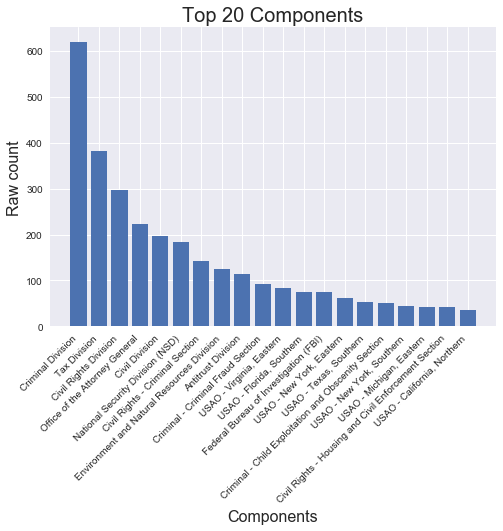

In [38]:
# Obtaining the frequency table for the components that appears in our data
from collections import Counter
component_counts = Counter()
for elem in df_1718['components']:
    for i in range(len(elem)):
        component_counts[elem[i]] += 1

# Sorting frequency table for histogram
from operator import itemgetter
sorted_components = sorted(component_counts.items(),
                                  reverse=True,
                                  key=itemgetter(1))

# graphing the top components
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

num_top_components = 20
items = [item for item, count in sorted_components[:num_top_components]]
counts = [count for item, count in sorted_components[:num_top_components]]
plt.bar(range(num_top_components), counts)
plt.xticks(range(num_top_components), items, rotation=45, ha='right')
plt.title("Top 20 Components", fontsize = 20)
plt.xlabel('Components', fontsize = 16)
plt.ylabel('Raw count', fontsize = 16)

In [39]:
import datetime
import calendar
from operator import itemgetter
from collections import Counter

date_counts = Counter()
month_counts = Counter()
year_counts = Counter()

# Creates frequency tables for month, year,and month-year 
for elem in df_1718['date']:
    m = [elem.month, elem.strftime("%B")]
    y = elem.year
    m_y = m[1] + '-' + str(y)
    date_counts[m_y] += 1
    month_counts[m[0]] += 1
    year_counts[y] += 1

#sorts month table & prints results
sorted_months = sorted(month_counts.items(),
                      key=itemgetter(0))

for token, count in sorted_months:
    print(calendar.month_name[token], ":", count, 'articles')

January : 240 articles
February : 204 articles
March : 244 articles
April : 280 articles
May : 236 articles
June : 255 articles
July : 209 articles
August : 101 articles
September : 103 articles
October : 123 articles
November : 107 articles
December : 106 articles


**Trying some Gaussian Mixture Modeling**

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer

# creating an instance of the vectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=50, stop_words='english')

# using the instance to construct a document matrix X
X = vectorizer.fit_transform(documents_list)
X = X.toarray()

# saving a list of unique words in the vocabulary
unique_vocabulary = list(vectorizer.vocabulary_.keys())

print("The number of unique words in the vocabulary is:", len(unique_vocabulary))

The number of unique words in the vocabulary is: 1694


In [168]:
%%time
from sklearn.metrics import calinski_harabaz_score

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

for k in range(2, 6):
    candidate_gmm = GaussianMixture(n_components=k, n_init=1, random_state=94775)
    candidate_gmm.fit(X)
    cluster_assignments = candidate_gmm.predict(X)
    score = calinski_harabaz_score(X, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

k = 2 has CH index 114.01315206011296
k = 3 has CH index 77.23125139409808
k = 4 has CH index 59.78744244158168
k = 5 has CH index 56.10285829927943
Best k within 2, 3, ..., 10 according to CH index: 2
Wall time: 51.1 s


In [170]:
from collections import Counter
assignments = Counter()

# looping over each cluster assignment
# counting the number of assignments per cluster
for item in list(best_cluster_assignments):
        assignments[item] += 1 

# printing the number of documents assigned to each cluster
print("Cluster", "# of Documents")
for k, v in assignments.items(): 
    print(str(k).ljust(10), str(v))

Cluster # of Documents
0          1832
1          376


**A couple of ideas that i'd like to try... we can pick a word we think would best characterize the top n clusters and then use Professor Chen's homework 2 histogram idea (like spam vs ham) to see which word falls to what extent in which cluster. Next I shall try tsne**

In [172]:
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))

In [174]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
cluster0 = get_indexes(0,best_cluster_assignments)
cluster1 = get_indexes(1,best_cluster_assignments)

In [175]:
comp_cluster0 = Counter()
comp_cluster1 = Counter()

for i in df_1718.loc[cluster0, "components"]:
    for j in i:
        comp_cluster0[j]+=1
        
for i in df_1718.loc[cluster1, "components"]:
    for j in i:
        comp_cluster1[j]+=1

from operator import itemgetter
sorted_cluster0 = sorted(comp_cluster0.items(),
                                  reverse=True,
                                  key=itemgetter(1))

sorted_cluster1 = sorted(comp_cluster1.items(),
                                  reverse=True,
                                  key=itemgetter(1))


print("Top 10 Components in Cluster 0:")
for k, v in sorted_cluster0[0:10]: 
    print(str(k).ljust(55), str(v))

print( )

print("Top 10 Components in Cluster 1:")
for k, v in sorted_cluster1[0:10]: 
    print(str(k).ljust(55), str(v))
    

Top 10 Components in Cluster 0:
Criminal Division                                       620
Civil Rights Division                                   297
Office of the Attorney General                          223
Civil Division                                          196
National Security Division (NSD)                        183
Civil Rights - Criminal Section                         143
Environment and Natural Resources Division              124
Antitrust Division                                      114
Criminal - Criminal Fraud Section                       92
Federal Bureau of Investigation (FBI)                   74

Top 10 Components in Cluster 1:
Tax Division                                            376
USAO - California, Northern                             21
USAO - North Carolina, Middle                           15
USAO - Florida, Southern                                15
USAO - Pennsylvania, Eastern                            11
USAO - Virginia, Eastern                 

**Trying out PCA**

In [185]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

In [186]:
pca.explained_variance_ratio_
#very little explained

array([0.05264712, 0.02528911])

In [188]:
%%time
from sklearn.metrics import calinski_harabaz_score

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

for k in range(2, 6):
    candidate_gmm = GaussianMixture(n_components=k, n_init=1, random_state=94775)
    candidate_gmm.fit(X_2d)
    cluster_assignments = candidate_gmm.predict(X_2d)
    score = calinski_harabaz_score(X_2d, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments_pca = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

k = 2 has CH index 3502.663694952105
k = 3 has CH index 4833.569791253931
k = 4 has CH index 4420.51875911736
k = 5 has CH index 3385.8766026235053
Best k within 2, 3, ..., 10 according to CH index: 3
Wall time: 175 ms


(-0.23615904937458299,
 0.7778477689159662,
 -0.41175135703568394,
 0.7152601196053312)

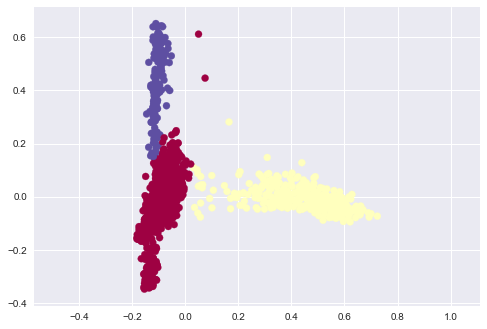

In [189]:
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=best_cluster_assignments_pca, cmap='Spectral')
plt.axis('equal')

**Trying out basic t-sne. Would need to play around with this more.**

In [190]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=94775)  # note: in practice you should actually play with the perplexity, learning rate, and number of iterations
X_tsne2d = tsne.fit_transform(X)

In [191]:
%%time
from sklearn.metrics import calinski_harabaz_score

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

for k in range(2, 6):
    candidate_gmm = GaussianMixture(n_components=k, n_init=1, random_state=94775)
    candidate_gmm.fit(X_2d)
    cluster_assignments = candidate_gmm.predict(X_2d)
    score = calinski_harabaz_score(X_2d, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments_tsne = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

k = 2 has CH index 3502.663694952105
k = 3 has CH index 4833.569791253931
k = 4 has CH index 4420.51875911736
k = 5 has CH index 3385.8766026235053
Best k within 2, 3, ..., 10 according to CH index: 3
Wall time: 107 ms


(-89.82380933590687, 79.77362317868032, -66.37305758885377, 74.1521293967151)

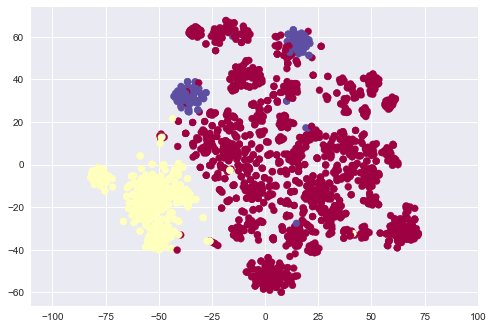

In [192]:
plt.scatter(X_tsne2d[:, 0], X_tsne2d[:, 1], c=best_cluster_assignments_tsne, cmap='Spectral')
plt.axis('equal')